Paxillin segmentation on zyxin data ( not the best data set to use)

Ran on exp #2

Currently have duplicated code for the same analysis.

As a continueing effort on paxillin seg and with more emphasis on the cluster

Will just keep the redundent code here, until no longer needed

Liya Ding 2024.02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
from tifffile import imread
from tifffile import imsave
from skimage.morphology import remove_small_objects    
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from scipy.ndimage import gaussian_filter
from joblib import dump, load

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import umap

# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


In [3]:
exp_list = ["TractionData_27_04_21_ZyxinPaxillin",'TractionData_21_07_27_ZyxinPaxillin']
exp_ID = exp_list[1]
print(exp_ID)

TractionData_21_07_27_ZyxinPaxillin


In [4]:
pny_dir =  '/mnt/d/lding/zyxin/data_pny_subset'
plot_output_dir = '/mnt/d/lding/zyxin/plot_pass2_output'
seg_output_dir = '/mnt/d/lding/zyxin/seg_pass2_output'

if not os.path.isdir(plot_output_dir):
    os.makedirs(plot_output_dir)

if not os.path.isdir(seg_output_dir):
    os.makedirs(seg_output_dir)

### mkdir related dir


In [5]:
exp_pny_dir = os.path.join(pny_dir, 'C467_'+exp_ID)

exp_plot_output_dir = os.path.join(plot_output_dir, exp_ID)
if not os.path.isdir(exp_plot_output_dir):
    os.makedirs(exp_plot_output_dir)

exp_seg_output_dir = os.path.join(seg_output_dir, exp_ID)
if not os.path.isdir(exp_seg_output_dir):
    os.makedirs(exp_seg_output_dir)

cellsubdirs = [x for x in os.listdir(exp_pny_dir) if os.path.isdir(os.path.join(exp_pny_dir, x)) and ('cell' in x)]

for cell_folder in cellsubdirs:
    
    cell_image_path = os.path.join(exp_pny_dir,cell_folder)
    cell_plot_path = os.path.join(exp_plot_output_dir,cell_folder)
    cell_seg_path = os.path.join(exp_seg_output_dir,cell_folder)
    if not os.path.isdir(cell_plot_path):
        os.makedirs(cell_plot_path)
    if not os.path.isdir(cell_seg_path):
        os.makedirs(cell_seg_path)
    

### for the exp, run through all cells

In [6]:
for cell_folder in cellsubdirs:
    
    prop_df_pax = pd.DataFrame(columns=['cell_ID','time_point','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                                  'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                                  'min_intensity','minor_axis_length','orientation','perimeter','solidity'])

    cell_image_path = os.path.join(exp_pny_dir,cell_folder)
    cell_plot_path = os.path.join(exp_plot_output_dir,cell_folder)
    cell_seg_path = os.path.join(exp_seg_output_dir,cell_folder)
    if not os.path.isdir(cell_plot_path):
        os.makedirs(cell_plot_path)
    if not os.path.isdir(cell_seg_path):
        os.makedirs(cell_seg_path)
    
    filenames = [x for x in os.listdir(cell_image_path) if os.path.isfile(os.path.join(cell_image_path, x)) and ('CellMask_Zyxin_PaxorActin_' in x)]

    for filename in filenames:
        struct_img0 = np.load(os.path.join(cell_image_path,filename))

        org_mask = struct_img0[0,:,:]
        input_zyxin_img = struct_img0[1,:,:]
        input_pax_img = struct_img0[2,:,:]

        ### intensity normalization
        intensity_scaling_param = [5,20]
        norm_zyxin_img = intensity_normalization(input_zyxin_img, scaling_param=intensity_scaling_param)
        norm_pax_img = intensity_normalization(input_pax_img, scaling_param=intensity_scaling_param)

        # smoothing with edge preserving smoothing 
        smooth_zyxin_img = gaussian_filter(norm_zyxin_img,sigma=1,mode='nearest',truncate=3)
        smooth_pax_img = gaussian_filter(norm_pax_img,sigma=1,mode='nearest',truncate=3)

        new_cell_mask = smooth_zyxin_img>0.1
        new_cell_mask = new_cell_mask*org_mask
        new_cell_mask = remove_small_objects(new_cell_mask>0, min_size=20, connectivity=1, in_place=False)

        ## PARAMETERS for vesselness filter step ##
        f2_param = [[1, 0.3]]
        pax_seg = filament_2d_wrapper(smooth_pax_img, f2_param)

        pax_seg = pax_seg*new_cell_mask
        pax_seg = remove_small_objects(pax_seg>0, min_size=2, connectivity=1, in_place=False)

        label_pax_seg = label(pax_seg*new_cell_mask)
        regionprops_pax = regionprops(label_pax_seg,intensity_image=input_pax_img)

        pax_image_label_overlay = label2rgb(label_pax_seg, image=smooth_pax_img*0, bg_label=0)
        
        imsave(os.path.join(cell_seg_path, 'cell_mask_'+filename[:-4] +'.tif'),new_cell_mask.astype(np.uint8))   
        imsave(os.path.join(cell_seg_path, 'pax_seg_'+filename[:-4] +'.tif'),pax_seg.astype(np.uint8))   
        imsave(os.path.join(cell_seg_path, 'pax_seglabel_'+filename[:-4] +'.tif'),label_pax_seg.astype(np.uint16))   
        imsave(os.path.join(cell_plot_path, 'pax_segrgb_'+filename[:-4] +'.tif'),pax_image_label_overlay.astype(np.uint8))   
                

        for iL in range(label_pax_seg.max()):           
            s = pd.Series([float(cell_folder[-1]),float(filename[-7:-4]),
                           regionprops_pax[iL].area,regionprops_pax[iL].bbox_area,regionprops_pax[iL].convex_area,
                           regionprops_pax[iL].eccentricity,regionprops_pax[iL].equivalent_diameter,regionprops_pax[iL].euler_number,
                           regionprops_pax[iL].extent,regionprops_pax[iL].filled_area,regionprops_pax[iL].label,
                           regionprops_pax[iL].major_axis_length,regionprops_pax[iL].max_intensity,regionprops_pax[iL].mean_intensity,
                           regionprops_pax[iL].min_intensity,regionprops_pax[iL].minor_axis_length,regionprops_pax[iL].orientation,
                           regionprops_pax[iL].perimeter,regionprops_pax[iL].solidity],
                           index=['cell_ID','time_point','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                                  'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                                  'min_intensity','minor_axis_length','orientation','perimeter','solidity'])
            prop_df_pax = prop_df_pax.append(s,ignore_index=True)

        prop_df_pax.to_csv(exp_ID+"_cell"+cell_folder[-1]+'.csv')
    
          

/mnt/d/lding/UbuntuGitCodes/focal_adhesion_clustering/utils/utils.py:107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


KeyboardInterrupt: 

In [16]:
prop_df_pax_all = pd.DataFrame(columns=['cell_ID','time_point','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                                  'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                                  'min_intensity','minor_axis_length','orientation','perimeter','solidity'])

for cell_folder in cellsubdirs:
    prop_df_pax = pd.read_csv(exp_ID+"_cell"+cell_folder[-1]+'.csv')
    prop_df_pax_all = prop_df_pax_all.append(prop_df_pax)

(array([1.54941e+05, 1.91190e+04, 6.50900e+03, 2.79000e+03, 1.48100e+03,
        8.89000e+02, 4.42000e+02, 2.71000e+02, 1.76000e+02, 1.37000e+02,
        8.40000e+01, 3.80000e+01, 6.10000e+01, 4.00000e+01, 2.20000e+01,
        3.10000e+01, 3.10000e+01, 3.00000e+01, 1.80000e+01, 1.80000e+01,
        1.50000e+01, 1.50000e+01, 5.00000e+00, 7.00000e+00, 1.00000e+00,
        4.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 3.00000e+00, 4.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 5.00000e+00, 2.00000e+00, 4.00000e+00, 1.00000e+00,
        2.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([   2.  ,   26.38,   50.76,   75.14,   99.52,  123.9 ,  148.28,
         172.66,  197.04,  221.42,  245.8 ,  270.18,  294.56,  318.94,
         343.32,  367.7 ,  392.08,  416.46,  440.84,  465.22,  489.6 ,
         513.98,  538.36,  562.74,  587.12,  611.5 ,  6

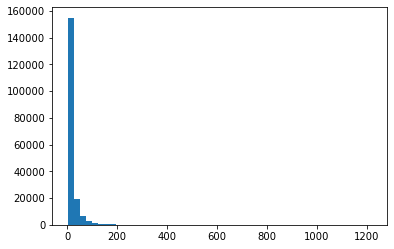

In [42]:
plt.hist(prop_df_pax_all_selected['area'],50)

11


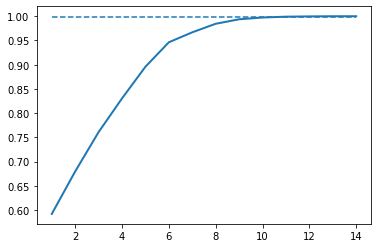

In [61]:
prop_df_pax_all_selected = prop_df_pax_all[['area', 'eccentricity', 'convex_area', 'bbox_area', 'equivalent_diameter', 'euler_number',
                                  'extent','filled_area','major_axis_length','mean_intensity',
                                  'minor_axis_length','orientation','perimeter','solidity']]

prop_df_pax_all_selected = prop_df_pax_all_selected[prop_df_pax_all_selected['area']<300]

cdf = []
cdf = sklearn.preprocessing.scale(prop_df_pax_all_selected, axis=0)

cdf.shape

FA_pca = sklearn.decomposition.PCA()
FA_pca.fit(cdf)

fig = plt.plot(figsize=(10,4))
cumsum = np.cumsum(FA_pca.explained_variance_ratio_)
plt.plot(np.arange(1, FA_pca.n_components_ + 1),
           cumsum, 
           '-', linewidth=2)
n_pc = FA_pca.n_components_

for i in range(FA_pca.n_components_):
    if cumsum[i]>0.999:
        n_pc = i+1
        break
print(n_pc)

plt.hlines(cumsum[n_pc-1], xmin=1, xmax=FA_pca.n_components_, linestyle='dashed')



In [62]:
FA_pca.explained_variance_ratio_*100

array([5.92123841e+01, 8.77488386e+00, 8.11525272e+00, 6.94978499e+00,
       6.53362114e+00, 5.04446197e+00, 2.05362245e+00, 1.76206845e+00,
       9.25031988e-01, 3.71065519e-01, 1.66771518e-01, 5.85849880e-02,
       3.23130012e-02, 1.53316646e-04])

Text(0.5, 1.0, 'features12')

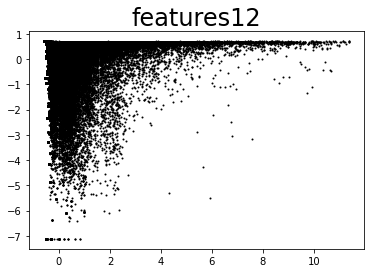

In [63]:
plt.scatter(cdf[:, 0], cdf[:, 1],c='k',s=1)
plt.title('features12', fontsize=24)

In [51]:
np.mean(cdf_trans[:, 0])

2.438742040921038e-18

Text(0.5, 1.0, 'PCA-1-2')

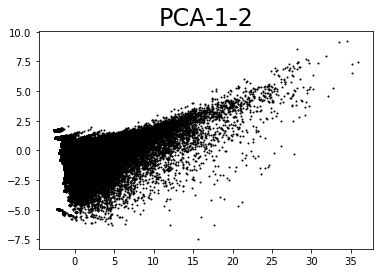

In [65]:
cdf_trans = FA_pca.transform(cdf)
plt.scatter(cdf_trans[:, 0], cdf_trans[:, 1],c='k',s=1)
plt.title('PCA-1-2', fontsize=24)

Text(0.5, 1.0, 'UMAP projection of the paxillin FA')

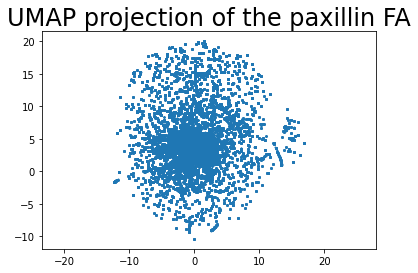

In [66]:
scaled_pax_PCA_data = StandardScaler().fit_transform(cdf_trans)

reducer = umap.UMAP(n_components=4,random_state=2)

reducer.fit(scaled_pax_PCA_data)

embedding = reducer.fit_transform(scaled_pax_PCA_data)
embedding.shape

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the paxillin FA', fontsize=24)


Text(0.5, 1.0, 'UMAP projection of the paxillin FA')

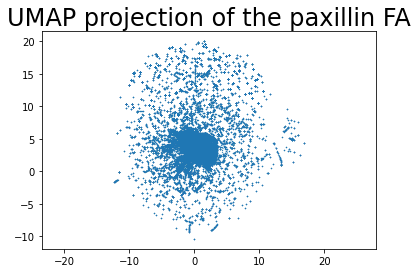

In [69]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],s=0.01)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the paxillin FA', fontsize=24)
